In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.encoding import OrdinalEncoder, mean_encoding, MeanEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

### Reading Data

In [19]:
train_data = pd.read_csv("C:/Users/IKECHUKWU_OKWUOSA/Desktop/Code Review/DSN Bootcamp Qualification Hackathon Qualification/archive/train.csv")
train = train_data.copy()
test_data = pd.read_csv("C:/Users/IKECHUKWU_OKWUOSA/Desktop/Code Review/DSN Bootcamp Qualification Hackathon Qualification/archive/test.csv")
test = test_data.copy()
print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head(2))

Train shape: (188533, 13)
Test shape: (125690, 12)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [7]:
feature_cols = [c for c in train.columns if c not in ['price']]
drop_cols = ['id']
feature_cols = [c for c in feature_cols if c not in drop_cols]
train = train.drop(columns=drop_cols)
test = test.drop(columns = drop_cols)
numeric_cols = []
cat_cols = []

# Checking for which features are numeric and categorical
for c in feature_cols:
    if c == 'ID':
        continue
    if pd.api.types.is_numeric_dtype(train[c]):
        numeric_cols.append(c)
    else:
        cat_cols.append(c)

print("Numeric features:", numeric_cols)
print("Categorical features:", cat_cols)

Numeric features: ['model_year', 'milage']
Categorical features: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [9]:
n_unique = []
n_unique_ = []
for col in cat_cols:
    n_unique.append(train[col].nunique())
    n_unique_.append(test[col].nunique())
unique_df = pd.DataFrame({
                            "Categorical Columns": cat_cols,
                            "Number of Unique Values in train": n_unique,
                            "Number of unique values in test": n_unique_
                        })
unique_df

,Categorical Columns,Number of Unique Values in train,Number of unique values in test
0,brand,57,55
1,model,1897,1891
2,fuel_type,7,7
3,engine,1117,1117
4,transmission,52,52
5,ext_col,319,317
6,int_col,156,156
7,accident,2,2
8,clean_title,1,1


In [11]:
print(train['accident'].value_counts()) 
print("% Null values in column",(train['accident'].isna().sum()/train.shape[0])*100)
# None reported -- 0
#'At least 1 accident or damage reported'-1

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64
% Null values in column 1.3005680703112983


In [13]:
print(train['clean_title'].value_counts())
print("% Null values in column",(train['clean_title'].isna().sum()/train.shape[0])*100)
#nan- 0
# Yes-1 

clean_title
Yes    167114
Name: count, dtype: int64
% Null values in column 11.360875814844086


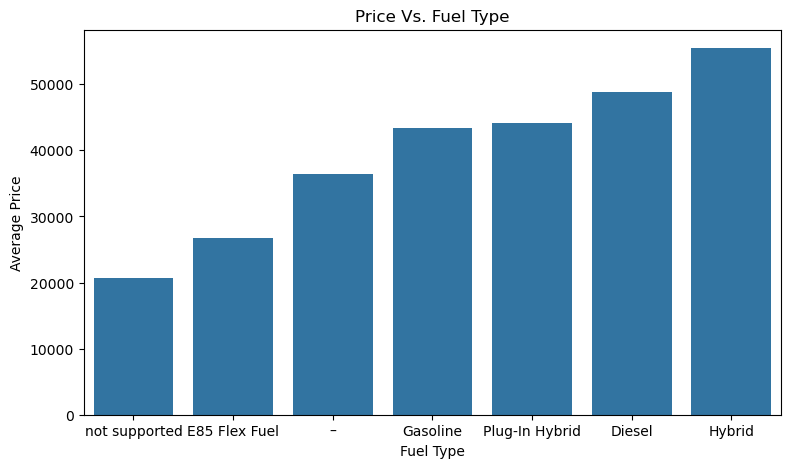

In [55]:
x = train.groupby('fuel_type')["price"].mean().sort_values()
plt.figure(figsize=(9,5))
plt.title("Price Vs. Fuel Type")
sns.barplot(x)
plt.xlabel("Fuel Type")
plt.ylabel('Average Price')
plt.show()

### Preprocessing

In [21]:
drop_cols = ['id', 'clean_title']
train = train.drop(columns=drop_cols)
test = test.drop(columns = drop_cols)
def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['accident', 'fuel_type'] 
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        if 'clean_title' in df.columns:
            df['clean_title'] = df['clean_title'].fillna(0)
            df['clean_title'] = df['clean_title'].replace("Yes", 1)
        return df
train = filling_missing_values_in_categorical_columns(train)
test = filling_missing_values_in_categorical_columns(test)
def categorical_encoding(df):
    one_hot_cols = ['fuel_type']
                    #['model', 'ext_col', 'int_col',  "engine"]
    if 'accident' in df.columns:
        accident_map = {'None reported':0, 'At least 1 accident or damage reported':1}
        df['accident'] = df['accident'].map(accident_map)
    #for col in one_hot_cols:
    df = pd.get_dummies(df, columns=one_hot_cols)
    # Changing dtype to category
    cat_features=['model','brand' ,'ext_col', 'int_col',  "engine", "transmission"]
    for feature in cat_features:
        df[feature] = pd.Series(df[feature], dtype="category")
    return df
train = categorical_encoding(train)
test = categorical_encoding(test)

C:\Users\IKECHUKWU_OKWUOSA\AppData\Local\Temp\ipykernel_19284\2653294848.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [ ]:
feature_col = [col for col in train.columns if col not in ['price']]
X = train[feature_col]
y = train['price']

# Base models

base_models = [
    XGBRegressor(
        n_estimators=500, max_depth=6,
        subsample=0.8, random_state=42
    ),
    LGBMRegressor(
        n_estimators=500, max_depth=-1,
        subsample=0.8, random_state=42
    ),
    CatBoostRegressor(
        n_estimators=500,  depth=6,
        verbose=0, random_state=42
    )
]

# Meta-model
meta_model = Ridge(alpha=1.0, random_state=42)

# =====================================
# 3. OOF Stacking
# =====================================
def oof_stacking(base_models, meta_model, X, y, X_test=None, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Storage
    oof_preds = np.zeros((X.shape[0], len(base_models)))
    test_preds = np.zeros((X_test.shape[0], len(base_models))) if X_test is not None else None

    for i, model in enumerate(base_models):
        print(f"\nTraining base model {i+1}: {model.__class__.__name__}")
        fold_preds = np.zeros((X_test.shape[0], n_splits)) if X_test is not None else None

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Fit
            model.fit(X_train, y_train)

            # Predict OOF
            oof_preds[val_idx, i] = model.predict(X_val)

            # Predict Test (if provided)
            if X_test is not None:
                fold_preds[:, fold] = model.predict(X_test)

            # Print fold score
            rmse = mean_squared_error(y_val, oof_preds[val_idx, i], squared=False)
            print(f"  Fold {fold+1}: RMSE = {rmse:.4f}")

        # Average test predictions across folds
        if X_test is not None:
            test_preds[:, i] = fold_preds.mean(axis=1)

    # Train meta-model on OOF predictions
    print("\nTraining meta-model...")
    meta_model.fit(oof_preds, y)

    # Final predictions
    final_oof_pred = meta_model.predict(oof_preds)
    if X_test is not None:
        final_test_pred = meta_model.predict(test_preds)
        return final_oof_pred, final_test_pred, oof_preds, test_preds
    else:
        return final_oof_pred, None, oof_preds, None



In [ ]:
# =====================================
# 4. Run stacking
# =====================================
# Example usage:
# X_train, y_train, X_test = ...
# final_oof, final_test, base_oof, base_test = oof_stacking(base_models, meta_model, X_train, y_train, X_test)

# Evaluate OOF performance
# rmse = mean_squared_error(y_train, final_oof, squared=False)
# print("Stacked Model OOF RMSE:", rmse)


In [ ]:
import matplotlib.pyplot as plt

# --- Run stacking ---
final_oof, final_test, base_oof, base_test = oof_stacking(
    base_models, meta_model, X, y, X_test=None
)

# --- Evaluate performance ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
base_rmse = []
for i in range(base_oof.shape[1]):  # loop over base models
    rmse = mean_squared_error(y, base_oof[:, i], squared=False)
    base_rmse.append(rmse)
    print(f"{base_models[i].__class__.__name__} OOF RMSE: {rmse:.4f}")

stacked_rmse = mean_squared_error(y, final_oof, squared=False)
print(f"\nStacked Model OOF RMSE: {stacked_rmse:.4f}")

# --- Visualization 1: RMSE comparison ---
model_names = [m.__class__.__name__ for m in base_models] + ["Stacked"]
rmse_scores = base_rmse + [stacked_rmse]

plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_scores, color=["skyblue", "lightgreen", "salmon", "orange"])
plt.ylabel("RMSE (lower is better)")
plt.title("Base Models vs Stacked Model Performance")
plt.xticks(rotation=20)
plt.show()

# --- Visualization 2: Meta-model weights ---
coefs = meta_model.coef_
plt.figure(figsize=(8, 5))
plt.bar(model_names[:-1], coefs, color=["skyblue", "lightgreen", "salmon"])
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.ylabel("Ridge Coefficient Weight")
plt.title("Meta-Model (Ridge) Weights on Base Learners")
plt.show()


### Training Catboost model

In [ ]:
import optuna
feature_col = [col for col in train.columns if col not in ['price']]
X = train[feature_col]
y = train['price']
cat_features=['brand','model', 'ext_col', 'int_col',  "engine", "transmission"]
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'iterations': trial.suggest_int('iterations', 300, 1000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        #'border_count': trial.suggest_int('border_count', 32, 128),
        'random_state': 42,
        'verbose': 0
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(**params, cat_features=cat_features)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-09-14 20:58:57,918] A new study created in memory with name: no-name-7de00248-23c5-4987-bed4-0025f5fd6128
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-09-14 21:03:42,550] Trial 0 finished with value: 7291

In [86]:
feature_col = [col for col in train.columns if col not in ['price']]
X = train[feature_col]
y = train['price']
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores =[]
catboost_preds = []
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    catboost_model = CatBoostRegressor(random_state=42, 
                                       verbose=0,
                                       cat_features=['brand','model', 'ext_col', 'int_col',  "engine", "transmission"])
    catboost_model.fit(X_train, y_train)
    y_pred = catboost_model.predict(X_test)
    catboost_preds.append(y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    scores.append(rmse)
print("RMSE per fold:", scores)
print("Average RMSE for all folds: ", np.mean(scores))



C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

RMSE per fold: [68174.59544588854, 68960.97046972757, 74171.03651227379, 76772.1157618774, 76571.7879146794]
Average RMSE for all folds:  72930.10122088934


C:\Users\IKECHUKWU_OKWUOSA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE per fold: [68274.94132524655, 68986.55123810688, 74175.08645967448, 76623.79112739969, 76573.29612577966]
Average RMSE for all folds:  72926.73325524144

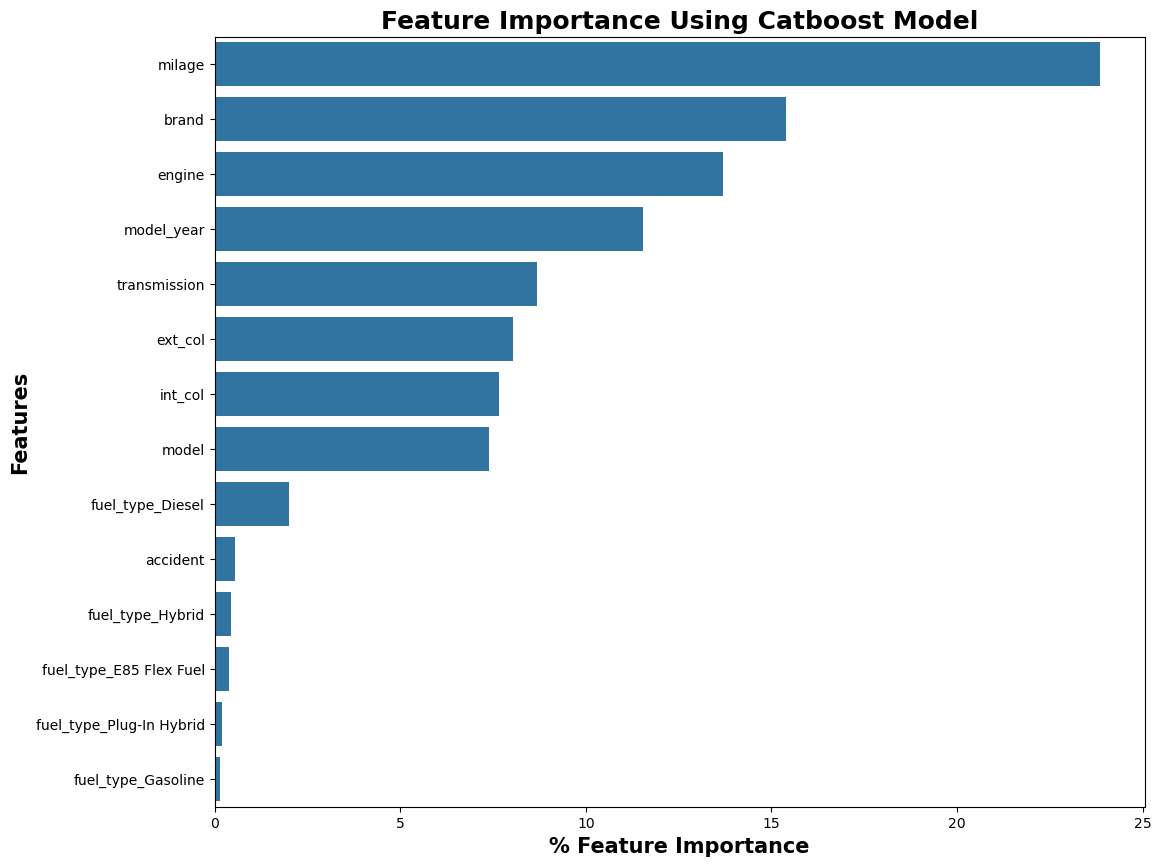

In [74]:
# Getting feature importances from the best trained model
feature_importances = catboost_model.feature_importances_
# Creating a pandas DataFrame to store the feature importances along with the feature names
tip= train.drop(columns=['price'])
importance_df = pd.DataFrame({"Feature": tip.columns, "Importance": feature_importances})
# Sorting the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df["% Importance"] = importance_df["Importance"]* 100
# Creating the plot
plt.figure(figsize=(12, 10))
sns.barplot(data = importance_df,x="Importance", y="Feature",orient="h")
plt.xlabel("% Feature Importance",fontsize=15,fontweight ="bold")
plt.ylabel("Features",fontsize=15,fontweight ="bold")
plt.title("Feature Importance Using Catboost Model",fontsize=18, fontweight ="bold" )
#plt.savefig("oil_feature.jpg", format="jpeg", quality=95,dpi = 300)
plt.show()


In [13]:
pred = lgbm_model.predict(test)
submission=pd.DataFrame({"id":test_data['id'],"Price":pred})
submission.to_csv("Submission.csv",index=False)